In [1]:
import tensorflow as tf

In [2]:
import os
import pandas as pd

datadir = '/Users/kesavreddy/Downloads/DataJPG'
category_dirs = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]

category_counts = pd.DataFrame({'Category': category_dirs,'Count': [len(os.listdir(os.path.join(datadir, d))) for d in category_dirs]})

In [3]:
category_counts

,Category,Count
0,G,28
1,A,127
2,E,3
3,B,18


In [4]:
img_size = 224

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

Found 42526 files belonging to 4 classes.
Using 34021 files for training.


2023-11-13 02:59:42.314865: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-13 02:59:42.314895: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-13 02:59:42.314905: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-13 02:59:42.314937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-13 02:59:42.314951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 42526 files belonging to 4 classes.
Using 8505 files for validation.


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import numpy as np

img_size = 224  # Specify the image size
batch_size = 32  # Specify your batch size
num_classes = 4  # Specify the number of classes

# Create a pre-trained DenseNet121 model (excluding the top classification layer)
base_model = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model using your TensorFlow datasets with callbacks
history = model.fit(
    train_ds,
    epochs=15,  # You can adjust the number of epochs
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)

Epoch 1/15


2023-11-13 03:00:54.624514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - ETA: 0s - loss: 1.0356 - accuracy: 0.6821

2023-11-13 03:04:58.166495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - 303s 283ms/step - loss: 1.0356 - accuracy: 0.6821 - val_loss: 0.6897 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 2/15
1064/1064 [==============================] - 299s 281ms/step - loss: 0.7106 - accuracy: 0.7404 - val_loss: 0.5138 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 3/15
1064/1064 [==============================] - 299s 281ms/step - loss: 0.6403 - accuracy: 0.7598 - val_loss: 0.5425 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 4/15
1064/1064 [==============================] - 299s 281ms/step - loss: 0.5946 - accuracy: 0.7753 - val_loss: 0.4844 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 5/15
1064/1064 [==============================] - 299s 281ms/step - loss: 0.5729 - accuracy: 0.7833 - val_loss: 0.4586 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 6/15
1064/1064 [==============================] - 299s 281ms/step - loss: 0.5630 - accuracy: 0.7886 - val_loss: 0.4670 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 7/15
1064/1064 [=======================

In [8]:
import matplotlib.pyplot as plt

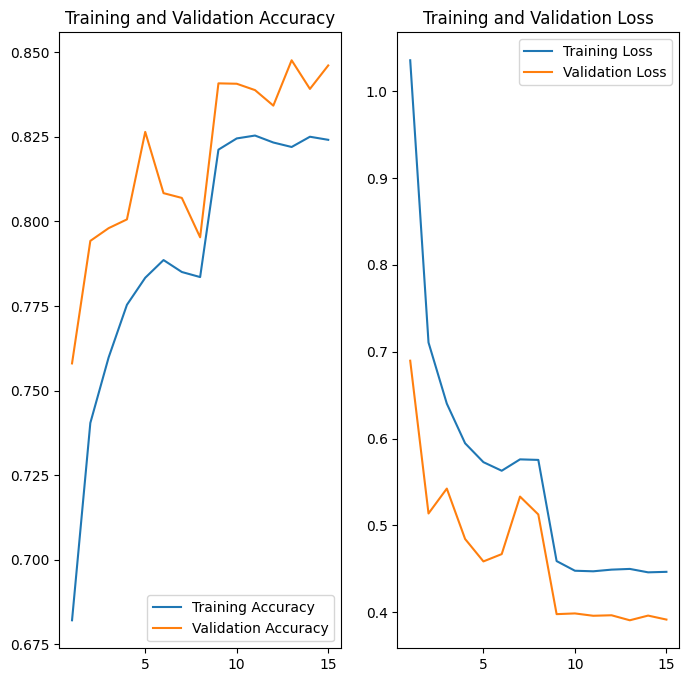

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Fix for the undefined 'epochs' variable
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
val_pred = model.predict(val_ds)
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Convert softmax predictions to class labels
val_pred_labels = np.argmax(val_pred, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)

# Calculate and print additional metrics
print("F1 score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))
print("Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(val_true_labels, val_pred_labels))

  1/266 [..............................] - ETA: 1:01

2023-11-13 04:16:40.076779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 58s 219ms/step
F1 score: 0.5770150894740217
Recall: 0.5853027630805409
Confusion Matrix:
 [[4657  314   10 1225]
 [ 500   31    1  146]
 [  19    1    0    5]
 [1223   81    2  290]]
